##### This notebook is a exploration space for NER models

##### `wikineural-multilingual-ner` model trained on the `wikineural` dataset. It has the following output classes:
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

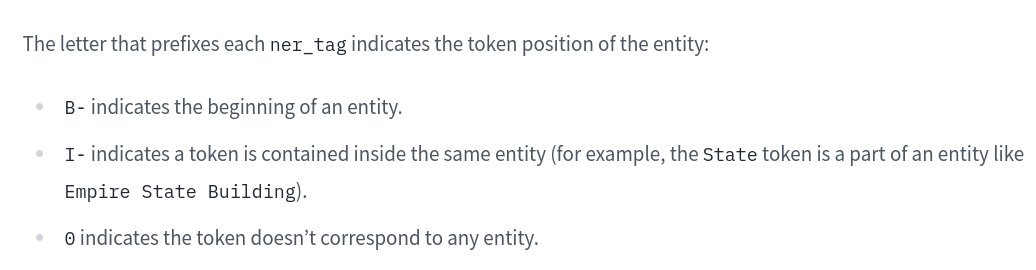

In [32]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline, BeamSearchScorer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

In [3]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

/home/aakash/miniconda3/envs/gsoc/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [41]:
example = "My name is Tom Andrew Wolfgang and I live in India"

In [42]:
ner_results = nlp(example)
print(ner_results)

[{'entity_group': 'PER', 'score': 0.997199, 'word': 'Tom Andrew Wolfgang', 'start': 11, 'end': 30}, {'entity_group': 'LOC', 'score': 0.99932563, 'word': 'India', 'start': 45, 'end': 50}]


Start and end make up the entity span

In [61]:
ner_results[1]

{'entity_group': 'LOC',
 'score': 0.99932563,
 'word': 'India',
 'start': 45,
 'end': 50}

In [62]:
example[45:50]

'India'

Works for `My name is Aakash` but not for `I am Aakash`. 
Does not get `GSoC` but gets `Google Summer of Code 2023`

In [73]:
example2 = "My name is Aakash. I am a contributor at DBpedia for Google Summer of Code 2023"
ner_results2 = nlp(example2)

In [74]:
ner_results2

[{'entity_group': 'PER',
  'score': 0.64120793,
  'word': 'Aakas',
  'start': 11,
  'end': 16},
 {'entity_group': 'MISC',
  'score': 0.9607172,
  'word': 'DBpedia',
  'start': 41,
  'end': 48},
 {'entity_group': 'MISC',
  'score': 0.7251432,
  'word': 'Google Summer of Code 2023',
  'start': 53,
  'end': 79}]

In [40]:
model.get_output_embeddings()

In [22]:
c = model.config

In [31]:
tokenized_example = tokenizer(example)
tokenized_example

{'input_ids': [101, 11590, 11324, 10124, 12275, 13999, 14290, 10111, 146, 11850, 17791, 26426, 33824, 118, 64301, 23315, 10550, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
tokens = tokenizer.tokenize(example)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [45]:
import torch
output = model(torch.tensor([token_ids]))

In [55]:
import torch.nn.functional as F
import torch
scores = output.logits[0]
probabilities = F.softmax(scores, dim=1)

In [90]:
for token, score in zip(tokens, probabilities):
    print(f"{token} - {max(score.tolist())} - {c.id2label[score.argmax().item()]}")

My - 0.9997811913490295 - O
name - 0.9999028444290161 - O
is - 0.9998801946640015 - O
Tom - 0.9975850582122803 - B-PER
Andrew - 0.9893339276313782 - I-PER
Wolfgang - 0.9911236763000488 - I-PER
and - 0.9973880648612976 - O
I - 0.9990083575248718 - O
live - 0.9997900128364563 - O
in - 0.9997662901878357 - O
India - 0.9978212118148804 - B-LOC


In [88]:
score.argmax().item()

5

In [96]:
def classify_all_words_as_entities(text, model, tokenizer):
    tokenized_text = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    output = model(torch.tensor([token_ids]))
    scores = output.logits[0]
    probabilities = F.softmax(scores, dim=1)
    all = []
    c = model.config
    for token, score in zip(tokenized_text, probabilities):
        print(f"{token} - {max(score.tolist())} - {c.id2label[score.argmax().item()]}")
        all.append((token, max(score.tolist()), c.id2label[score.argmax().item()]))
    return all

In [95]:
text = "My name is Aakash. I have a chair. It is made of Wood and is made in Nagpur"
all_words_text = classify_all_words_as_entities(text, model, tokenizer)

My - 0.999977707862854 - O
name - 0.9999823570251465 - O
is - 0.9999819993972778 - O
Aa - 0.5417144298553467 - B-PER
##kas - 0.7050730586051941 - O
##h - 0.7240643501281738 - O
. - 0.9999775886535645 - O
I - 0.999980092048645 - O
have - 0.9999840259552002 - O
a - 0.999988317489624 - O
chair - 0.9999873638153076 - O
. - 0.9999878406524658 - O
It - 0.9999895095825195 - O
is - 0.9999881982803345 - O
made - 0.9999656677246094 - O
of - 0.9998868703842163 - O
Wood - 0.5832104086875916 - B-LOC
and - 0.9999886751174927 - O
is - 0.9999895095825195 - O
made - 0.9999868869781494 - O
in - 0.9999805688858032 - O
Nag - 0.9997501969337463 - B-LOC
##pur - 0.9991851449012756 - I-LOC


In [97]:
def extract_entities_wikineural(text, pipe):
    return pipe(text)

In [98]:
extract_entities_wikineural(text, nlp)

[{'entity_group': 'PER',
  'score': 0.5343278,
  'word': 'Aa',
  'start': 11,
  'end': 13},
 {'entity_group': 'LOC',
  'score': 0.5456473,
  'word': 'Wood',
  'start': 49,
  'end': 53},
 {'entity_group': 'LOC',
  'score': 0.9992676,
  'word': 'Nagpur',
  'start': 69,
  'end': 75}]

In [101]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/aakash/nltk_data...


True

In [102]:
from nltk.corpus import wordnet as wn

loc = wn.synsets("location")[0]

In [104]:
def is_location(candidate):
    for ss in wn.synsets(candidate):
        # only get those where the synset matches exactly
        name = ss.name().split(".", 1)[0]
        if name != candidate:
            continue
        hit = loc.lowest_common_hypernyms(ss)
        if hit and hit[0] == loc:
            return True
    return False


In [107]:
for word in ("countryside", "town", "village", "home"):
    print(is_location(word), word, sep="\t")

True	countryside
True	town
True	village
True	home


In [114]:
wn.synsets('chair', wn.NOUN)

[Synset('chair.n.01'),
 Synset('professorship.n.01'),
 Synset('president.n.04'),
 Synset('electric_chair.n.01'),
 Synset('chair.n.05')]

`LUKE` model

In [115]:
from transformers import AutoTokenizer, LukeForEntityClassification

tokenizer = AutoTokenizer.from_pretrained("studio-ousia/luke-large-finetuned-open-entity")
model = LukeForEntityClassification.from_pretrained("studio-ousia/luke-large-finetuned-open-entity")

KeyboardInterrupt: 